In [1]:
import numpy as np
import pandas as pd
import types
import sys
from collections import defaultdict
from pprint import pformat
import math

from pyqstrat.evaluator import compute_return_metrics, display_return_metrics, plot_return_metrics
from pyqstrat.account import Account
from pyqstrat.pq_utils import *
from pyqstrat.plot import TimeSeries, trade_sets_by_reason_code, Subplot, Plot



<Figure size 432x288 with 0 Axes>

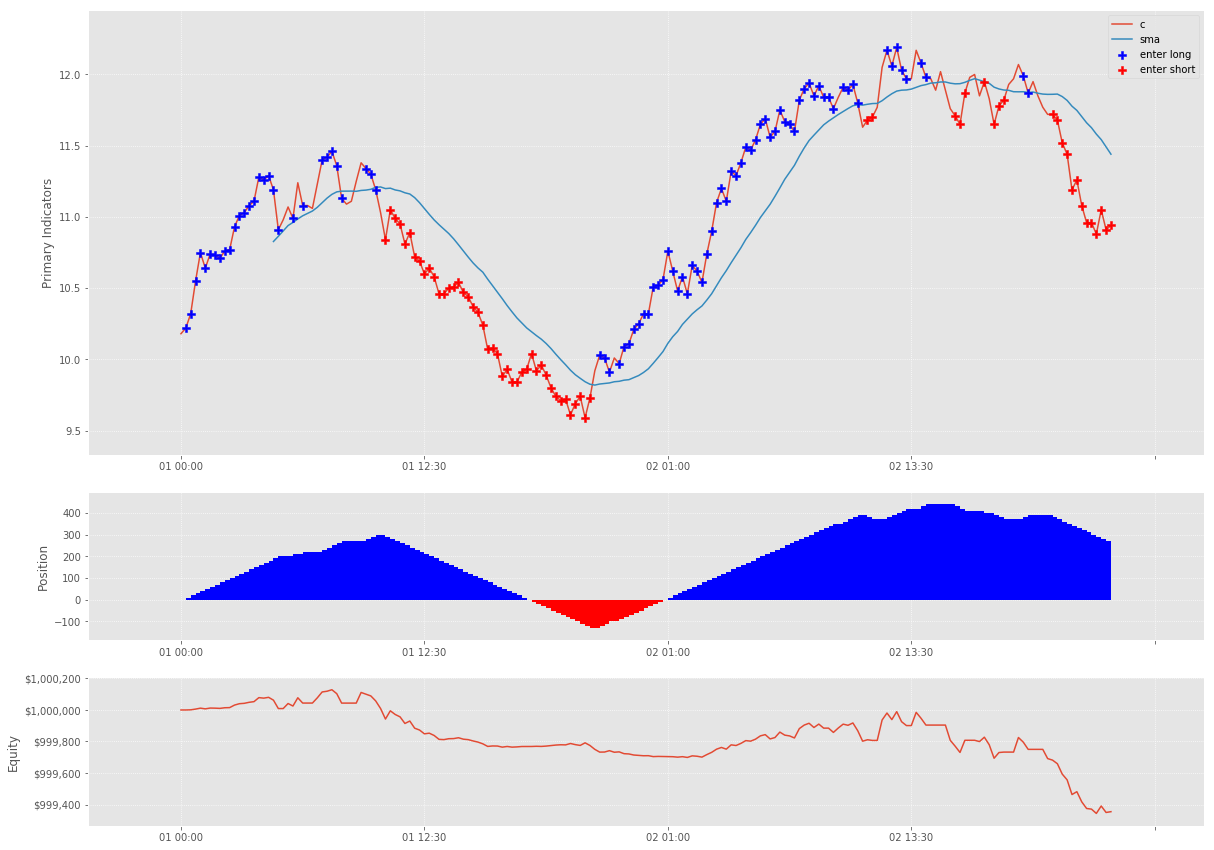

In [3]:
def _get_time_series_list(timestamps, names, values, properties):
    ts_list = []
    for name in names:
        line_type, color = None, None
        if properties is not None and name in properties:
            if 'line_type' in properties[name]: line_type = properties[name]['line_type']
            if 'color' in properties[name]: color = properties[name]['color']
        ts = TimeSeries(name, timestamps, getattr(values, name), line_type = line_type, color = color)
        ts_list.append(ts)
    return ts_list

class Strategy:
    def __init__(self, contracts, timestamps, price_function, starting_equity = 1.0e6, calc_frequency = 'D', 
                 strategy_context = None, exclude_order_timestamps = None, exclude_trade_timestamps = None):
        '''
        Args:
            contracts (list of Contract): The contracts we will potentially trade
            timestamps (np.array of np.datetime64): The "heartbeat" of the strategy.  We will evaluate trading rules and simulate the market
                at these times.
            starting_equity (float, optional): Starting equity in Strategy currency.  Default 1.e6
            calc_frequency (str, optional): How often P&L is calculated.  Default is 'D' for daily
            exclude_order_timestamps (np.array of np.datetime64, optional): Don't evaluate trade rules at these times.  Default None
            strategy_context (:obj:`types.SimpleNamespace`, optional): A storage class where you can store key / value pairs 
                relevant to this strategy.  For example, you may have a pre-computed table of correlations that you use in the 
                indicator or trade rule functions.  
                If not set, the __init__ function will create an empty member strategy_context object that you can access.
            exclude_trade_timestamps (np.array of np.datetime64, optional): Don't evaluate market simulators at these times.  Default None
        '''
        self.name = None
        self.timestamps = timestamps
        if strategy_context is None: strategy_context = types.SimpleNamespace()
        self.strategy_context = strategy_context
        self.account = Account(contracts, timestamps, price_function, strategy_context, starting_equity, calc_frequency)
        self.symbols = [contract.symbol for contract in contracts]
        self.exclude_order_timestamps = exclude_order_timestamps
        self.exclude_trade_timestamps = exclude_trade_timestamps
        self.indicators = {}
        self.signals = {}
        self.signal_values = defaultdict(types.SimpleNamespace)
        self.rules = {}
        self.rule_signals = {}
        self.market_sims = {}
        self._trades = defaultdict(list)
        self._orders = []
        self.indicator_deps = {}
        self.indicator_symbols = {}
        self.indicator_values = defaultdict(types.SimpleNamespace)
        self.signal_indicator_deps = {}
        self.signal_deps = {}
        self.signal_symbols = {}
        
    def add_indicator(self, name, indicator_function, symbols = None, depends_on = None):
        '''
        Args:
            name: Name of the indicator
            indicator_function:  A function that takes strategy timestamps and other indicators and returns a numpy array
              containing indicator values.  The return array must have the same length as the timestamps object
            symbols (list of str, optional): Symbols that this indicator applies to.  If not set, it applies to all symbols.  Default None.
            depends_on (list of str, optional): Names of other indicators that we need to compute this indicator.
                Default None.
        '''
        
        self.indicators[name] = indicator_function
        self.indicator_deps[name] = [] if depends_on is None else depends_on
        if symbols is None: symbols = self.symbols
        self.indicator_symbols[name] = symbols
        
    def add_signal(self, name, signal_function, symbols = None, depends_on_indicators = None, depends_on_signals = None):
        '''
        Args:
            name (str): Name of the signal
            signal_function (function):  A function that takes timestamps and a dictionary of indicator value arrays and returns a numpy array
              containing signal values.  The return array must have the same length as the input timestamps
            symbols (list of str, optional): Symbols that this signal applies to. If not set, it applies to all symbols.  Default None.
            depends_on_indicators (list of str, optional): Names of indicators that we need to compute this signal. Default None.
            depends_on_signals (list of str, optional): Names of other signals that we need to compute this signal. Default None.
        '''
        self.signals[name] = signal_function
        self.signal_indicator_deps[name] = [] if depends_on_indicators is None else depends_on_indicators
        self.signal_deps[name] = [] if depends_on_signals is None else depends_on_signals
        if symbols is None: symbols = self.symbols
        self.signal_symbols[name] = symbols
        
    def add_rule(self, name, rule_function, signal_name, sig_true_values = None):
        '''Add a trading rule
        
        Args:
            name (str): Name of the trading rule
            rule_function (function): A trading rule function that returns a list of Orders
            signal_name (str): The strategy will call the trading rule function when the signal with this name matches sig_true_values
            sig_true_values (numpy array, optional): If the signal value at a bar is equal to one of these values, 
                the Strategy will call the trading rule function.  Default [TRUE]
        '''
        if sig_true_values is None: sig_true_values = [True]
        self.rule_signals[name] = (signal_name, sig_true_values)
        self.rules[name] = rule_function
        
    def add_market_sim(self, market_sim_function, symbols = None):
        '''Add a market simulator.  A market simulator takes a list of Orders as input and returns a list of Trade objects.
        
        Args:
            market_sim_function (function): A function that takes a list of Orders and Indicators as input and returns a list of Trade objects
            symbols (list of str, optional): A list of the symbols that this market_sim_function applies to. 
                If None (default) it will apply to all symbols
        '''
        if symbols is None: symbols = self.symbols
        for symbol in symbols: self.market_sims[symbol] = market_sim_function
        
    def run_indicators(self, indicator_names = None, symbols = None, clear_all = False):
        '''Calculate values of the indicators specified and store them.
        
        Args:
            indicator_names (list of str, optional): List of indicator names.  If None (default) run all indicators
            symbols (list of str, optional): List of symbols to run these indicators for.  If None (default) use all symbols
            clear_all (bool, optional): If set, clears all indicator values before running.  Default False.
        '''
        if indicator_names is None: indicator_names = self.indicators.keys()
        if symbols is None: symbols = self.symbols
            
        if clear_all:  self.indicator_values = defaultdict(types.SimpleNamespace)
            
        ind_names = []
            
        for ind_name, symbol_list in self.indicator_symbols.items():
            if len(set(symbols).intersection(symbol_list)): ind_names.append(ind_name)
                
        indicator_names = list(set(ind_names).intersection(indicator_names))
         
        for symbol in symbols:
            for indicator_name in indicator_names:
                # First run all parents
                parent_names = self.indicator_deps[indicator_name]
                for parent_name in parent_names:
                    if symbol in self.indicator_values and hasattr(self.indicator_values[symbol], parent_name): continue
                    self.run_indicators([parent_name], [symbol])
                # Now run the actual indicator
                if symbol in self.indicator_values and hasattr(self.indicator_values[symbol], indicator_name): continue
                indicator_function = self.indicators[indicator_name]
                parent_values = types.SimpleNamespace()
                for parent_name in parent_names:
                    setattr(parent_values, parent_name, getattr(self.indicator_values[symbol], parent_name))
                if isinstance(indicator_function, np.ndarray):
                    setattr(self.indicator_values[symbol], indicator_name, indicator_function)
                else:
                    setattr(self.indicator_values[symbol], indicator_name, series_to_array(
                        indicator_function(symbol, self.timestamps, parent_values, self.strategy_context)))
                
    def run_signals(self, signal_names = None, symbols = None, clear_all = False):
        '''Calculate values of the signals specified and store them.
        
        Args:
            signal_names (list of str, optional): List of signal names.  If None (default) run all signals
            symbols (list of str, optional): List of symbols to run these signals for.  If None (default) use all symbols
            clear_all (bool, optional): If set, clears all signal values before running.  Default False.
        '''
        if signal_names is None: signal_names = self.signals.keys()
        if symbols is None: symbols = self.symbols
            
        if clear_all: self.signal_values = defaultdict(types.SimpleNamespace)
            
        sig_names = []
        
        for sig_name, symbol_list in self.signal_symbols.items():
            if len(set(symbols).intersection(symbol_list)): sig_names.append(sig_name)
                
        signal_names = list(set(sig_names).intersection(signal_names))
        
        for symbol in symbols:
            for signal_name in signal_names:
                # First run all parent signals
                parent_names = self.signal_deps[signal_name]
                for parent_name in parent_names:
                    if symbol in self.signal_values and hasattr(self.signal_values[symbol], parent_name): continue
                    self.run_signals([parent_name], [symbol])
                # Now run the actual signal
                if symbol in self.signal_values and hasattr(self.signal_values[symbol], signal_name): continue
                signal_function = self.signals[signal_name]
                parent_values = types.SimpleNamespace()
                for parent_name in parent_names:
                    setattr(parent_values, parent_name, getattr(self.signal_values[symbol], parent_name))
                    
                # Get indicators needed for this signal
                indicator_values = types.SimpleNamespace()
                for indicator_name in self.signal_indicator_deps[signal_name]:
                    setattr(indicator_values, indicator_name, getattr(self.indicator_values[symbol], indicator_name))
                    
                setattr(self.signal_values[symbol], signal_name, series_to_array(
                    signal_function(symbol, self.timestamps, indicator_values, parent_values, self.strategy_context)))
                
    def run_rules(self, rule_names = None, symbols = None, start_date = None, end_date = None):
        '''Run trading rules.
        
        Args:
            rule_names: List of rule names.  If None (default) run all rules
            symbols: List of symbols to run these signals for.  If None (default) use all symbols
            start_date: Run rules starting from this date. Default None 
            end_date: Don't run rules after this date.  Default None
        '''
        start_date, end_date = str2date(start_date), str2date(end_date)
        timestamps, orders_iter, trades_iter = self._get_iteration_indices(rule_names, symbols, start_date, end_date)
        # Now we know which rules, symbols need to be applied for each iteration, go through each iteration and apply them
        # in the same order they were added to the strategy
        for i, tup_list in enumerate(orders_iter):
            timestamp = self.timestamps[i]
            if timestamp not in self.exclude_trade_timestamps:
                self._check_for_trades(i, trades_iter[i])
            if timestamp not in self.exclude_order_timestamps:
                self._check_for_orders(i, tup_list)
        
    def _get_iteration_indices(self, rule_names = None, symbols = None, start_date = None, end_date = None):
        '''
        >>> class MockStrat:
        ...    def __init__(self):
        ...        self.timestamps = timestamps
        ...        self.account = self
        ...        self.rules = {'rule_a' : rule_a, 'rule_b' : rule_b}
        ...        self.market_sims = {'IBM' : market_sim_ibm, 'AAPL' : market_sim_aapl}
        ...        self.rule_signals = {'rule_a' : ('sig_a', [1]), 'rule_b' : ('sig_b', [1, -1])}
        ...        self.signal_values = {'IBM' : types.SimpleNamespace(sig_a = np.array([0., 1., 1.]), sig_b = np.array([0., 0., 0.]))},
        ...                              'AAPL' : types.SimpleNamespace(sig_a = np.array([0., 0., 0.]), sig_b = np.array([0., -1., -1]))}}
        ...        self.indicator_values = {'IBM' : types.SimpleNamespace(), 'AAPL' : types.SimpleNamespace()}
        >>>
        >>> def market_sim_aapl(): pass
        >>> def market_sim_ibm(): pass
        >>> def rule_a(): pass
        >>> def rule_b(): pass
        >>> timestamps = np.array(['2018-01-01', '2018-01-02', '2018-01-03'], dtype = 'M8[D]')
        >>> rule_names = ['rule_a', 'rule_b']
        >>> symbols = ['IBM', 'AAPL']
        >>> start_date = np.datetime64('2018-01-01')
        >>> end_date = np.datetime64('2018-02-05')
        >>> timestamps, orders_iter, trades_iter = Strategy._get_iteration_indices(MockStrat(), rule_names, symbols, start_date, end_date)
        >>> assert(len(trades_iter[1]) == 0)
        >>> assert(trades_iter[2][1][1] == "AAPL")
        >>> assert(trades_iter[2][2][1] == "IBM")
        >>> assert(len(orders_iter[0]) == 0)
        >>> assert(len(orders_iter[1]) == 2)
        >>> assert(orders_iter[1][0][1] == "IBM")
        >>> assert(orders_iter[1][1][1] == "AAPL")
        >>> assert(len(orders_iter[2]) == 0)
        '''
        start_date, end_date = str2date(start_date), str2date(end_date)
        if rule_names is None: rule_names = self.rules.keys()
        if symbols is None: symbols = self.symbols

        num_timestamps = len(self.timestamps)

        orders_iter = [[] for x in range(num_timestamps)]
        trades_iter = [[] for x in range(num_timestamps)]

        for rule_name in rule_names:
            rule_function = self.rules[rule_name]
            for symbol in symbols:
                market_sim = self.market_sims[symbol]
                signal_name = self.rule_signals[rule_name][0]
                sig_true_values = self.rule_signals[rule_name][1]
                sig_values = getattr(self.signal_values[symbol], signal_name)
                timestamps = self.timestamps

                null_value = False if sig_values.dtype == np.dtype('bool') else np.nan
                if start_date: sig_values[0:np.searchsorted(timestamps, start_date)] = null_value
                if end_date:   sig_values[np.searchsorted(timestamps, end_date):] = null_value

                indices = np.nonzero(np.isin(sig_values, sig_true_values))[0]
                
                # Don't run rules on last index since we cannot fill any orders
                if len(indices) and indices[-1] == len(sig_values) -1: indices = indices[:-1] 
                indicator_values = self.indicator_values[symbol]
                iteration_params = {'market_sim' : market_sim, 'indicator_values' : indicator_values, 'signal_values' : sig_values}
                for idx in indices: orders_iter[idx].append((rule_function, symbol, iteration_params))

            self.orders_iter = orders_iter
            self.trades_iter = trades_iter # For debugging

        return self.timestamps, orders_iter, trades_iter
         
    def _check_for_trades(self, i, tup_list):
        for tup in tup_list:
            try:
                open_orders, symbol, params = tup
                open_orders = self._sim_market(i, open_orders, symbol, params)
                if len(open_orders): self.trades_iter[i + 1].append((open_orders, symbol, params))
            except Exception as e:
                raise type(e)(f'Exception: {str(e)} at rule: {type(tup[0])} symbol: {tup[1]} index: {i}').with_traceback(sys.exc_info()[2])
                
    def _check_for_orders(self, i, tup_list):
        for tup in tup_list:
            try:
                rule_function, symbol, params = tup
                open_orders = self._get_orders(i, rule_function, symbol, params)
                self._orders += open_orders
                if len(open_orders): self.trades_iter[i + 1].append((open_orders, symbol, params))
            except Exception as e:
                raise type(e)(f'Exception: {str(e)} at rule: {type(tup[0])} symbol: {tup[1]} index: {i}').with_traceback(sys.exc_info()[2])
                    
    def _get_orders(self, idx, rule_function, symbol, params):
        indicator_values, signal_values = (params['indicator_values'], params['signal_values'])
        open_orders = rule_function(symbol, idx, self.timestamps, indicator_values, signal_values, self.account, self.strategy_context)
        return open_orders
        
    def _sim_market(self, idx, open_orders, symbol, params):
        '''
        Keep iterating while we have open orders since they may get filled
        TODO: For limit orders and trigger orders we can be smarter here and reduce indices like quantstrat does
        '''
        market_sim_function = params['market_sim']
        trades = market_sim_function(open_orders, idx, self.timestamps, params['indicator_values'], params['signal_values'], 
                                     self.strategy_context)
        if len(trades) == 0: return []
        self._trades[symbol] += trades
        self.account._add_trades(symbol, trades)
        self.account.calc(idx)
        open_orders = [order for order in open_orders if order.status == 'open']
        return open_orders
            
    def df_data(self, symbols = None, add_pnl = True, start_date = None, end_date = None):
        '''
        Add indicators and signals to end of market data and return as a pandas dataframe.
        
        Args:
            symbols: list of symbols to include.  All if set to None (default)
            add_pnl: If True (default), include P&L columns in dataframe
            start_date: string or numpy datetime64. Default None
            end_date: string or numpy datetime64: Default None
        '''
        start_date, end_date = str2date(start_date), str2date(end_date)
        if symbols is None: symbols = self.symbols
        if not isinstance(symbols, list): symbols = [symbols]
            
        timestamps = self.timestamps
        
        if start_date: timestamps = timestamps[timestamps >= start_date]
        if end_date: timestamps = timestamps[timestamps <= end_date]
            
        dfs = []
             
        for symbol in symbols:
            df = pd.DataFrame({'timestamp' : self.timestamps})
            if add_pnl: 
                df_pnl = self.account.df_pnl(symbol)
                del df_pnl['symbol']

            indicator_values = self.indicator_values[symbol]
            
            for k in sorted(indicator_values.__dict__):
                name = k
                # Avoid name collisions
                if name in df.columns: name = name + '.ind'
                df.insert(len(df.columns), name, getattr(indicator_values, k))

            signal_values = self.signal_values[symbol]

            for k in sorted(signal_values.__dict__):
                name = k
                if name in df.columns: name = name + '.sig'
                df.insert(len(df.columns), name, getattr(signal_values, k))
            
            if add_pnl: df = pd.merge(df, df_pnl, left_index = True, right_index = True, how = 'left')
            # Add counter column for debugging
            df.insert(len(df.columns), 'i', np.arange(len(df)))
            
            dfs.append(df)
            
        return pd.concat(dfs)
    
    def trades(self, symbol = None, start_date = None, end_date = None):
        '''Returns a list of trades with the given symbol and with trade date between (and including) start date and end date if they are specified.
          If symbol is None trades for all symbols are returned'''
        start_date, end_date = str2date(start_date), str2date(end_date)
        return self.account.trades(symbol, start_date, end_date)
    
    def df_trades(self, symbol = None, start_date = None, end_date = None):
        '''Returns a dataframe with data from trades with the given symbol and with trade date between (and including) start date and end date
          if they are specified.  If symbol is None, trades for all symbols are returned'''
        start_date, end_date = str2date(start_date), str2date(end_date)
        return self.account.df_trades(symbol, start_date, end_date)
    
    def orders(self, symbol = None, start_date = None, end_date = None):
        '''Returns a list of orders with the given symbol and with order date between (and including) start date and end date if they are specified.
          If symbol is None orders for all symbols are returned'''
        start_date, end_date = str2date(start_date), str2date(end_date)
        return [order for order in self._orders if (symbol is None or order.symbol == symbol) and (
            start_date is None or order.date >= start_date) and (end_date is None or order.date <= end_date)]
    
    def df_orders(self, symbol = None, start_date = None, end_date = None):
        '''Returns a dataframe with data from orders with the given symbol and with order date between (and including) start date and end date
          if they are specified.  If symbol is None, orders for all symbols are returned'''
        start_date, end_date = str2date(start_date), str2date(end_date)
        orders = self.orders(symbol, start_date, end_date)
        df_orders = pd.DataFrame.from_records([(order.symbol, type(order).__name__, order.date, order.qty, order.params()) 
                                               for order in orders], columns = ['symbol', 'type', 'date', 'qty', 'params'])
        return df_orders
   
    def df_pnl(self, symbol = None):
        '''Returns a dataframe with P&L columns.  If symbol is set to None (default), sums up P&L across symbols'''
        return self.account.df_pnl(symbol)
    
    def df_returns(self, symbol = None, sampling_frequency = 'D'):
        '''Return a dataframe of returns and equity indexed by date.
        
        Args:
            symbol: The symbol to get returns for.  If set to None (default), this returns the sum of PNL for all symbols
            sampling_frequency: Downsampling frequency.  Default is None.  See pandas frequency strings for possible values
        '''
        pnl = self.df_pnl(symbol)[['equity']]
        pnl.equity = pnl.equity.ffill()
        pnl = pnl.resample(sampling_frequency).last()
        pnl['ret'] = pnl.equity.pct_change()
        return pnl
    
    def plot(self, 
             symbols = None, 
             primary_indicators = None,
             secondary_indicators = None,
             indicator_properties = None,
             signals = None,
             signal_properties = None, 
             pnl_columns = 'equity', 
             title = None, 
             figsize = (20, 15), 
             date_range = None, 
             date_format = None, 
             sampling_frequency = None, 
             trade_marker_properties = None, 
             hspace = 0.15):
        
        '''Plot indicators, signals, trades, position, pnl
        
        Args:
            symbols (list of str, optional): List of symbols or None (default) for all symbols
            primary indicators (list of str, optional): List of indicators to plot in the main indicator section. 
                Default None (plot everything)
            primary indicators (list of str, optional): List of indicators to plot in the secondary indicator section. 
                Default None (don't plot anything)
            indicator_properties (dict of str : dict, optional): If set, we use the line color, line type indicated 
                for the given indicators
            signals (list of str, optional): Signals to plot.  Default None (plot everything).
            pnl_columns (list of str, optional): List of P&L columns to plot.  Default is 'equity'
            title (list of str, optional): Title of plot. Default None
            figsize (tuple of int): Figure size.  Default (20, 15)
            date_range (tuple of str or np.datetime64, optional): Used to restrict the date range of the graph.
                Default None
            date_format (str, optional): Date format for tick labels on x axis.  If set to None (default), 
                will be selected based on date range. See matplotlib date format strings
            sampling_frequency (str, optional): Downsampling frequency.  The graph may get too busy if you have too many bars
                of data, in which case you may want to downsample before plotting.  See pandas frequency strings for 
                possible values. Default None.
            trade_marker_properties (dict of str : tuple, optional): A dictionary of 
                order reason code -> marker shape, marker size, marker color for plotting trades with different reason codes.
                Default is None in which case the dictionary from the ReasonCode class is used
            hspace (float, optional): Height (vertical) space between subplots.  Default is 0.15
        '''
        date_range = strtup2date(date_range)
        if symbols is None: symbols = self.symbols
        if not isinstance(symbols, list): symbols = [symbols]
        if not isinstance(pnl_columns, list): pnl_columns = [pnl_columns]
        
        for symbol in symbols:
            primary_indicator_names = [ind_name for ind_name in self.indicator_values[symbol].__dict__ \
                                       if hasattr(self.indicator_values[symbol], ind_name)]
            if primary_indicators:
                primary_indicator_names = list(set(primary_indicator_names).intersection(primary_indicators))
            secondary_indicator_names = []
            if secondary_indicators:
                secondary_indicator_names = secondary_indicators
            signal_names = [sig_name for sig_name in self.signals.keys() if hasattr(self.signal_values[symbol], sig_name)]
            if signals:
                signal_names = list(set(signal_names).intersection(signals))
 
            primary_indicator_list = _get_time_series_list(self.timestamps, primary_indicator_names, 
                                                           self.indicator_values[symbol], indicator_properties)
            secondary_indicator_list = _get_time_series_list(self.timestamps, secondary_indicator_names, 
                                                             self.indicator_values[symbol], indicator_properties)
            signal_list = _get_time_series_list(self.timestamps, signal_names, self.signal_values[symbol], signal_properties)
            df_pnl_ = self.df_pnl(symbol)
            pnl_list = [TimeSeries(pnl_column, timestamps = df_pnl_.index.values, values = df_pnl_[pnl_column].values
                                  ) for pnl_column in pnl_columns]
            
            if trade_marker_properties:
                trade_sets = trade_sets_by_reason_code(self._trades[symbol], trade_marker_properties)
            else:
                trade_sets = trade_sets_by_reason_code(self._trades[symbol])
                
            primary_indicator_subplot = Subplot(primary_indicator_list + trade_sets, height_ratio = 0.5, ylabel = 'Primary Indicators')
            if len(secondary_indicator_list):
                secondary_indicator_subplot = Subplot(secondary_indicator_list + trade_sets, height_ratio = 0.5, 
                                                      ylabel = 'Secondary Indicators')
            signal_subplot = Subplot(signal_list, ylabel = 'Signals', height_ratio = 0.167)
            pnl_subplot = Subplot(pnl_list, ylabel = 'Equity', height_ratio = 0.167, log_y = True, y_tick_format = '${x:,.0f}')
            position = df_pnl_.position.values
            pos_subplot = Subplot([TimeSeries('position', timestamps = df_pnl_.index.values, values = position, 
                                              plot_type = 'filled_line')], ylabel = 'Position', height_ratio = 0.167)
            
            title_full = title
            if len(symbols) > 1:
                if title is None: title = ''
                title_full = f'{title} {symbol}'
                
            plot_list = [primary_indicator_subplot]
            if len(secondary_indicator_list): plot_list.append(secondary_indicator_subplot)
            plot_list += [pos_subplot, pnl_subplot]
                
            plot = Plot(plot_list, figsize = figsize, date_range = date_range, date_format = date_format, 
                        sampling_frequency = sampling_frequency, 
                        title = title_full, hspace = hspace)
            plot.draw()
            
    def evaluate_returns(self, symbol = None, plot = True, float_precision = 4):
        '''Returns a dictionary of common return metrics.
        
        Args:
            symbol (str): Date frequency.  Default 'D' for daily so we downsample to daily returns before computing metrics
            plot (bool): If set to True, display plots of equity, drawdowns and returns.  Default False
            float_precision (float, optional): Number of significant figures to show in returns.  Default 4
        '''
        returns = self.df_returns(symbol)
        ev = compute_return_metrics(returns.index.values, returns.ret.values, self.account.starting_equity)
        display_return_metrics(ev.metrics(), float_precision = float_precision)
        if plot: plot_return_metrics(ev.metrics())
        return ev.metrics()
    
    def plot_returns(self, symbol = None):
        '''Display plots of equity, drawdowns and returns for the given symbol or for all symbols if symbol is None (default)'''
        if symbol is None:
            symbols = self.symbols()
        else:
            symbols = [symbol]
            
        df_list = []
            
        for symbol in symbols:
            df_list.append(self.df_returns(symbol))
        
        df = pd.concat(df_list, axis = 1)
            
        ev = compute_return_metrics(returns.index.values, returns.ret.values, self.account.starting_equity)
        plot_return_metrics(ev.metrics())
       
    def __repr__(self):
        return f'{pformat(self.indicators)} {pformat(self.rules)} {pformat(self.account)}'
    
if __name__ == "__main__":
    from pyqstrat.pq_types import Contract, Trade
    from pyqstrat.pq_utils import ReasonCode
    from pyqstrat.orders import MarketOrder
    from pyqstrat.portfolio import Portfolio
    
    def price_function(symbol, timestamps, i, strategy_context):
        return prices[i]
    
    def sma(symbol, timestamps, parent_indicators, strategy_context):
        return pd.Series(parent_indicators.c).rolling(window = 20).mean()
    
    def signal(symbol, timestamps, indicators, parent_signals, strategy_context):
        sma = np.nan_to_num(indicators.sma)
        signal = np.where(indicators.c > (sma + 0.1), 1, 0)
        signal = np.where(indicators.c < (sma - 0.1), -1, signal)
        return signal
    
    def rule(symbol, i, timestamps, indicator_values, signal_values, account, strategy_context):
        timestamp = timestamps[i]
        curr_pos = account.position(symbol, timestamp)
        signal_value = signal_values[i]
        risk_percent = 0.1
        timestamp = timestamps[i]

        if signal_value == 1:
            return [MarketOrder(symbol, timestamp, 10, reason_code = ReasonCode.ENTER_LONG)]
        if signal_value == -1:
            return [MarketOrder(symbol, timestamp, -10, reason_code = ReasonCode.ENTER_SHORT)]
        return []

    def market_simulator(orders, i, timestamps, indicators, signals, strategy_context):
        c = indicators.c[i]
        trades = []
    
        for order in orders:
            trades.append(Trade(order.symbol, timestamps[i], order.qty, c, order = order, commission = 0.01))
            order.status = 'filled'
                           
        return trades
        
    contract = Contract("IBM")
    timestamps = np.arange(np.datetime64('2019-01-01'), np.datetime64('2019-01-03'), np.timedelta64(15, 'm'))
    np.random.seed(0)
    returns = np.random.normal(size = len(timestamps)) / 100
    prices = np.round(np.cumprod(1 + returns) * 10, 2)
    strategy = Strategy([contract], timestamps, price_function)
    strategy.add_indicator('c', prices)
    strategy.add_indicator('sma', sma, depends_on = ['c'])
    strategy.add_signal('signal', signal, depends_on_indicators=['sma', 'c'])
    strategy.add_rule('rule', rule, signal_name = 'signal', sig_true_values = [1, -1])
    strategy.add_market_sim(market_simulator)
    portfolio = Portfolio()
    portfolio.add_strategy('strategy', strategy)
    portfolio.run()
    strategy.plot()